# IE 582 Statistical Learning for Data Mining
##### Homework 2
##### Fatih Mehmet Yılmaz - 2024702054

### 1. Introduction

In [1]:
# Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")

# Load the match data
match_data = pd.read_csv("match_data.csv")

#### Calculate Raw Probabilities

To compute the raw probabilities for match outcomes, we use the formula:

$$
P(x) = \frac{1}{\text{odd}}
$$

where:
- $P(x)$ is the probability of the outcome \(x\).
- $\text{odd}$ represents the bookmaker's odds for the corresponding outcome.

##### Calculations:
1. **Home Win**:
   $$
   P(\text{home win}) = \frac{1}{\text{odd_home}}
   $$
   
2. **Draw**:
   $$
   P(\text{draw}) = \frac{1}{\text{odd_draw}}
   $$

3. **Away Win**:
   $$
   P(\text{away win}) = \frac{1}{\text{odd_away}}
   $$

These probabilities provide the implied likelihood of each outcome based on the bookmaker's odds.


### 2 - First Task

In [2]:
# Filter out rows where 'suspended' or 'stopped' is True since these rows contain invalid odds.

filtered_data = match_data[(match_data['suspended'] != True) & (match_data['stopped'] != True)]

# Calculate P(home win), P(draw), P(away win)

filtered_data['P_home'] = 1 / filtered_data['1']
filtered_data['P_draw'] = 1 / filtered_data['X']
filtered_data['P_away'] = 1 / filtered_data['2']

#### Normalize Probabilities

After calculating the raw probabilities for match outcomes, we normalize them so that their sum equals 1. This is done using the following formula:

$$
P_{\text{normalized}}(x) = \frac{P(x)}{\sum P(x)}
$$

where:
- $P(x)$ is the raw probability of the outcome \(x\).
- $\sum P(x)\$ is the sum of raw probabilities for all outcomes (Home Win, Draw, and Away Win).

##### Calculations:
1. Compute the sum of raw probabilities:
   $$
   \text{Sum} = P(\text{home win}) + P(\text{draw}) + P(\text{away win})
   $$

2. Normalize each probability:
   - For Home Win:
     $$
     P_{\text{normalized}}(\text{home win}) = \frac{P(\text{home win})}{\text{Sum}}
     $$
   - For Draw:
     $$
     P_{\text{normalized}}(\text{draw}) = \frac{P(\text{draw})}{\text{Sum}}
     $$
   - For Away Win:
     $$
     P_{\text{normalized}}(\text{away win}) = \frac{P(\text{away win})}{\text{Sum}}
     $$

##### Purpose:
Normalization ensures that the probabilities are comparable and add up to 1, reflecting a proper probability distribution.


In [3]:
# Normalize probabilities

prob_sum = filtered_data[['P_home', 'P_draw', 'P_away']].sum(axis=1)

filtered_data['P_home_norm'] = filtered_data['P_home'] / prob_sum
filtered_data['P_draw_norm'] = filtered_data['P_draw'] / prob_sum
filtered_data['P_away_norm'] = filtered_data['P_away'] / prob_sum

#### Calculate Difference Between Probabilities

To analyze the difference in probabilities, we calculate the difference between the probabilities of a home win and an away win for both raw and normalized probabilities.

##### Raw Probability Difference:
The difference in raw probabilities is computed as:
$$
\Delta = P(\text{home win}) - P(\text{away win})
$$

##### Normalized Probability Difference:
The difference in normalized probabilities is computed as:
$$
\Delta_{\text{norm}} = P_{\text{normalized}}(\text{home win}) - P_{\text{normalized}}(\text{away win})
$$

##### Purpose:
1. The raw probability difference $(\Delta)$ provides insight into the bookmakers' unadjusted predictions for home and away wins.
2. The normalized probability difference $(\Delta_{\text{norm}})$ ensures the values are properly scaled and comparable, accounting for normalization effects.

##### Next Step:
The calculated differences $(\Delta)$ and $(\Delta_{\text{norm}})$ will be discretized into bins to perform further analysis.


In [4]:
# Calculate P(home win) - P(away win)

filtered_data['home_minus_away'] = filtered_data['P_home'] - filtered_data['P_away']
filtered_data['home_minus_away_norm'] = filtered_data['P_home_norm'] - filtered_data['P_away_norm']

#### Discretize into Bins

To analyze how the differences between probabilities correspond to match outcomes, we discretize the probability differences into bins.

##### Discretization:
1. **Bins for Raw Differences ($(\Delta)$)**:
   - The raw probability differences ($(\Delta)$) are grouped into equal intervals (bins). For example:
     $$
     (-1, -0.8], (-0.8, -0.6], \ldots, (0.8, 1]
     $$
   - These bins represent ranges of probability differences between home win and away win.

2. **Bins for Normalized Differences ($(\Delta_{\text{norm}})$)**:
   - Similarly, the normalized probability differences ($(\Delta_{\text{norm}})$) are grouped into the same bins for consistency.

##### Assignment:
Each match is assigned to a bin based on:
- The raw probability difference ($(\Delta)$).
- The normalized probability difference ($(\Delta_{\text{norm}})$)).

##### Purpose:
Discretization helps in aggregating matches into groups where differences in probabilities are similar. This enables further analysis, such as calculating empirical probabilities of draws for each bin.


In [5]:
# Bin values
bins = np.linspace(-1, 1, 21)  # Example bins: 20 equal intervals from -1 to 1
filtered_data['bin'] = pd.cut(filtered_data['home_minus_away'], bins)
filtered_data['bin_norm'] = pd.cut(filtered_data['home_minus_away_norm'], bins)

### Step 6: Calculate Empirical Probabilities of Draws

After assigning matches to bins based on probability differences, we calculate the empirical probability of draws for each bin.

#### Steps:
1. **Count Matches in Each Bin**:
   - For each bin:
     - Count the total number of matches assigned to that bin.
     - Count the number of matches that ended as a draw $(\text{result} = X)$.

2. **Calculate Empirical Probability**:
   - The empirical probability of draws for each bin is computed as:
     $$
     P_{\text{empirical}}(\text{draw}) = \frac{\text{Matches Ending in Draw}}{\text{Total Matches in Bin}}
     $$

#### Purpose:
This step helps determine how often matches end in a draw for each range of probability differences. It provides a real-world comparison against the bookmakers' implied probabilities.


In [6]:
# Calculate empirical probabilities
empirical_probs = filtered_data.groupby('bin')['result'].apply(lambda x: (x == 'X').mean())
empirical_probs_norm = filtered_data.groupby('bin_norm')['result'].apply(lambda x: (x == 'X').mean())

#### Visualization

To better understand the relationship between probability differences and match outcomes, we create visualizations.

1. **Plot Variables**:
   - $x$-axis: Probability Difference $(\Delta)$ or Normalized Probability Difference $(\Delta_{\text{norm}})$.
   - $y$-axis: Empirical Probability of Draws $(P_{\text{empirical}}(\text{draw}))$.

2. **Plot Details**:
   - Create scatter plot:
     
     * Raw probabilities ($(\Delta)$).


3. **Labels and Titles**:
   - Label the axes:
     - $x$-axis: $(P(\text{home win}) - P(\text{away win}))$
     - $y$-axis: Empirical $(P(\text{draw})$

##### Purpose:
Visualizing the empirical probabilities against probability differences allows us to identify trends and biases in bookmakers' odds for draws.


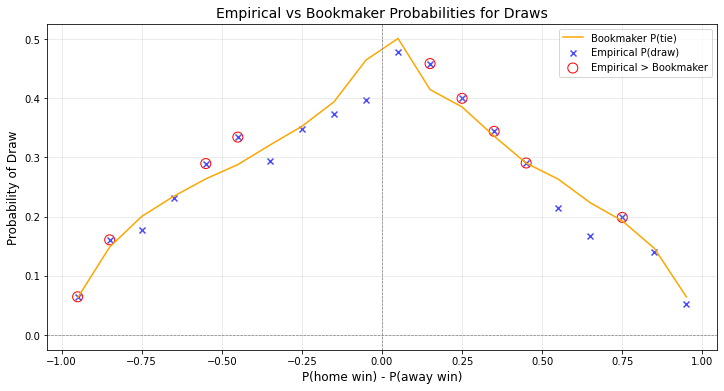

In [7]:
filtered_data['P_tie'] = 1 / filtered_data['X']  # Ensure P_tie is calculated if not present

# Calculate empirical probabilities of draws within each bin
draw_counts = filtered_data[filtered_data['result'] == 'X'].groupby('bin').size()
total_counts = filtered_data.groupby('bin').size()
empirical_draw_probabilities = (draw_counts / total_counts).fillna(0)

# Calculate average bookmaker probabilities of a draw within each bin
average_bookmaker_tie_probabilities = filtered_data.groupby('bin')['P_tie'].mean()

larger_points = empirical_draw_probabilities > average_bookmaker_tie_probabilities

# Midpoints of bins for plotting
bin_midpoints = [(interval.left + interval.right) / 2 for interval in filtered_data['bin'].cat.categories]

plt.figure(figsize=(12, 6))

plt.scatter(
    bin_midpoints,
    empirical_draw_probabilities,
    label='Empirical P(draw)',
    color='blue',
    marker='x',
    alpha=0.7
)

# Highlight points where empirical > bookmaker with red circles
plt.scatter(
    [bin_midpoints[i] for i in range(len(bin_midpoints)) if larger_points[i]],
    [empirical_draw_probabilities[i] for i in range(len(empirical_draw_probabilities)) if larger_points[i]],
    facecolors='none',  # Hollow circles
    edgecolors='red',
    s=100,  # Larger size for emphasis
    label='Empirical > Bookmaker'
)

# Line plot for bookmaker probabilities
plt.plot(
    bin_midpoints,
    average_bookmaker_tie_probabilities,
    label='Bookmaker P(tie)',
    color='orange'
)

# Add horizontal and vertical lines at 0 for reference
plt.axhline(0, color='grey', linestyle='--', linewidth=0.7)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.7)

# Axis labels and title
plt.xlabel('P(home win) - P(away win)', fontsize=12)
plt.ylabel('Probability of Draw', fontsize=12)
plt.title('Empirical vs Bookmaker Probabilities for Draws', fontsize=14)

# Legend and display
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Bias Analysis in Bookmaker's Tie Probabilities

We analyze the relationship between $P(\text{home win})$ - $P(\text{away win})$ and $P(\text{tie})$.

1. **X-axis**: $P(\text{home win})$ - $P(\text{away win})$
   - Negative values indicate games where the away team is favored.
   - Positive values indicate games where the home team is favored.
   - Values around zero indicate evenly matched teams.


2. **Y-axis**: $P(\text{tie})$, the probability of a draw.


3. **Plot Overview**:
   - **Bookmaker's Predictions**: Represented as a smooth orange line $P_{\text{Bookmaker}}(\text{tie})$.
   - **Empirical Probabilities**: Blue 'x' markers represent actual probabilities of draws calculated from match results.
   - **Bias Detection**: Red circles highlight where $P_{\text{Empirical}}(\text{tie})$ > $P_{\text{Bookmaker}}(\text{tie})$.


4. **Observations**:
   - For games near $P(\text{home win})$ - $P(\text{away win}) \approx 0$, the empirical draw probability exceeds the bookmaker's estimates consistently.
   - This suggests a **potential bias** where bookmakers may systematically **underestimate** the draw probability for closely matched games.


5. **Conclusion**:
   Betting on "Draw" in these scenarios may provide an opportunity to generate profits in the long run.


$\text{Potential Bias: } P_{\text{Empirical}}(\text{tie}) > P_{\text{Bookmaker}}(\text{tie}) \quad \text{for closely matched games.}$


### 3 - Second Task

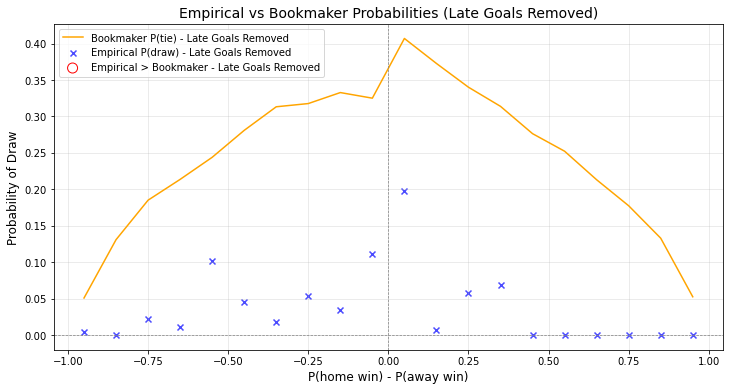

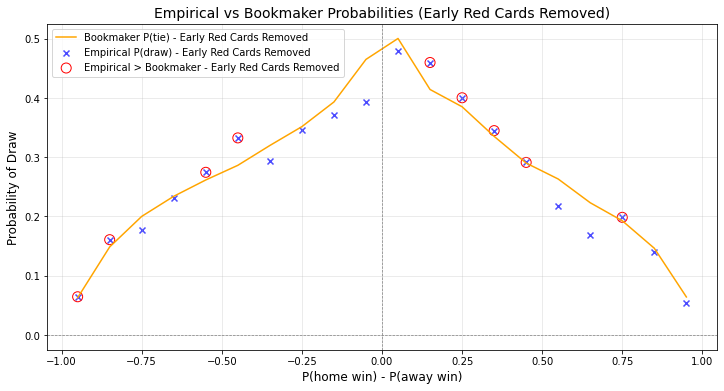

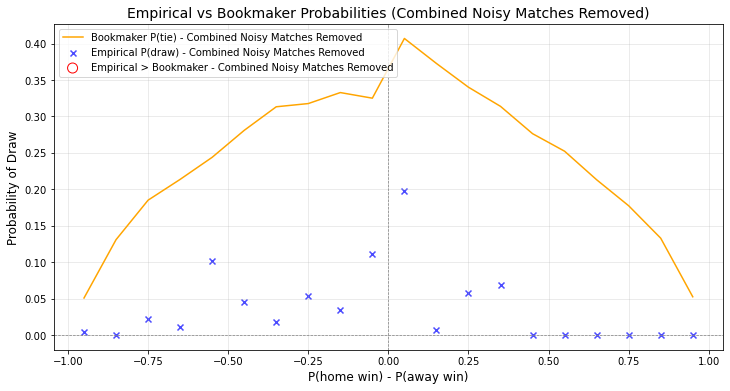

In [8]:
# Adjust minute values to the full match timeline
filtered_data['adjusted_minute'] = filtered_data.apply(lambda row: row['minute'] if row['halftime'] == '1st-half' else row['minute'] + 45, axis=1)
match_data['adjusted_minute'] = match_data.apply(lambda row: row['minute'] if row['halftime'] == '1st-half' else row['minute'] + 45, axis=1)



noisy_goals = filtered_data[
    (filtered_data['adjusted_minute'] > 90) &
    (filtered_data['result'].isin(['1', 'X', '2']))
]['fixture_id'].unique()


# Fill missing values in red card-related columns
match_data['Redcards - home'] = match_data['Redcards - home'].fillna(0)
match_data['Redcards - away'] = match_data['Redcards - away'].fillna(0)
match_data['Yellowred Cards - home'] = match_data['Yellowred Cards - home'].fillna(0)
match_data['Yellowred Cards - away'] = match_data['Yellowred Cards - away'].fillna(0)

# Filter matches with early direct red cards or yellow-red cards for the home team
early_red_cards_home = match_data[
    ((match_data['Redcards - home'] > 0) | (match_data['Yellowred Cards - home'] > 0)) & 
    (match_data['adjusted_minute'] <= 15)
]['fixture_id'].unique()

# Filter matches with early direct red cards or yellow-red cards for the away team
early_red_cards_away = match_data[
    ((match_data['Redcards - away'] > 0) | (match_data['Yellowred Cards - away'] > 0)) & 
    (match_data['adjusted_minute'] <= 15)
]['fixture_id'].unique()

# Combine home and away filters
early_red_cards_combined = set(early_red_cards_home).union(set(early_red_cards_away))

# Case 1: Remove matches with late goals
filtered_goals_removed = filtered_data[~filtered_data['fixture_id'].isin(noisy_goals)]

# Case 2: Remove matches with early red cards
filtered_data_without_early_red_cards = filtered_data[~filtered_data['fixture_id'].isin(early_red_cards_combined)]

# Combined case: Remove both types of noisy matches
noisy_matches = set(noisy_goals).union(early_red_cards_combined)
filtered_cleaned = filtered_data[~filtered_data['fixture_id'].isin(noisy_matches)]

# Function to recalculate probabilities, normalize, and bin
def process_and_plot(data, title_suffix):
    
    # Recalculate probabilities and normalization
    data['P_home'] = 1 / data['1']
    data['P_draw'] = 1 / data['X']
    data['P_away'] = 1 / data['2']

    prob_sum = data[['P_home', 'P_draw', 'P_away']].sum(axis=1)

    data['P_home_norm'] = data['P_home'] / prob_sum
    data['P_draw_norm'] = data['P_draw'] / prob_sum
    data['P_away_norm'] = data['P_away'] / prob_sum

    # Bin data
    bins = np.linspace(-1, 1, 21)
    data['bin'] = pd.cut(data['P_home'] - data['P_away'], bins)

    # Empirical probabilities
    empirical_probs = data.groupby('bin')['result'].apply(lambda x: (x == 'X').mean())
    average_bookmaker_tie_probs = data.groupby('bin')['P_draw'].mean()

    # Midpoints of bins
    bin_midpoints = [(interval.left + interval.right) / 2 for interval in data['bin'].cat.categories]

    # Identify points where empirical probabilities are greater than bookmaker probabilities
    larger_points = empirical_probs > average_bookmaker_tie_probs

    # Plot
    plt.figure(figsize=(12, 6))
    plt.scatter(
        bin_midpoints,
        empirical_probs,
        label=f'Empirical P(draw) - {title_suffix}',
        color='blue',
        marker='x',
        alpha=0.7
    )
    plt.scatter(
        [bin_midpoints[i] for i in range(len(bin_midpoints)) if larger_points[i]],
        [empirical_probs.iloc[i] for i in range(len(empirical_probs)) if larger_points[i]],
        facecolors='none',  # Hollow circles
        edgecolors='red',
        s=100,  # Larger size for emphasis
        label=f'Empirical > Bookmaker - {title_suffix}'
    )
    plt.plot(
        bin_midpoints,
        average_bookmaker_tie_probs,
        label=f'Bookmaker P(tie) - {title_suffix}',
        color='orange'
    )
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.7)
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.7)
    plt.xlabel('P(home win) - P(away win)', fontsize=12)
    plt.ylabel('Probability of Draw', fontsize=12)
    plt.title(f'Empirical vs Bookmaker Probabilities ({title_suffix})', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


# Process and plot for each case
process_and_plot(filtered_goals_removed, "Late Goals Removed")
process_and_plot(filtered_data_without_early_red_cards, "Early Red Cards Removed")
process_and_plot(filtered_cleaned, "Combined Noisy Matches Removed")


#### Analysis of Noisy Matches and Their Impact on Results

##### Observations to Highlight

1. **Late Goals Removed** (First Plot)

- Empirical probabilities (blue crosses) are consistently **lower** than bookmaker tie probabilities (orange line) across most bins.
- The trend suggests that removing late goals may stabilize the dataset, but empirical probabilities remain below bookmaker estimates.

2. **Early Red Cards Removed** (Second Plot)
- The empirical probabilities show more overlap with bookmaker tie probabilities compared to the previous plot.
- Several red circles appear, particularly in the middle bins, indicating that empirical probabilities exceed bookmaker predictions in certain areas.
- This suggests that early red cards may skew the outcomes in a way that increases the empirical draw probability compared to bookmaker estimates.

3. **Combined Noisy Matches Removed** (Third Plot)
- The pattern is similar to the **Late Goals Removed** plot.
- Removing both noisy cases (late goals and early red cards) results in a dataset where empirical draw probabilities align closely but remain lower than bookmaker estimates.

---

###### Key Takeaways
- Removing **early red cards** has the most noticeable effect, as shown by the increased frequency of red circles (empirical probabilities exceeding bookmaker probabilities).
- Removing **late goals** or combining both noisy match conditions tends to stabilize the empirical probabilities but does not drastically change the overall trends.
- Bookmaker tie probabilities appear consistently higher than empirical probabilities, suggesting the bookmakers might overestimate the likelihood of a draw in noisy scenarios.

---

### 4 - Third Part

In [9]:
# Select features and target
features = ['P_home_norm', 'P_draw_norm', 'P_away_norm', 'adjusted_minute']  
target = 'result'

# Drop missing values
filtered_cleaned = filtered_cleaned.dropna(subset=features + [target])

# Encode the target variable (One-hot encoding)
one_hot_encoded = pd.get_dummies(filtered_cleaned['result'], prefix='result')
filtered_cleaned = pd.concat([filtered_cleaned, one_hot_encoded], axis=1)
filtered_cleaned = filtered_cleaned.drop(columns=['result'])

# Features and target
X = filtered_cleaned[features]
y = filtered_cleaned[['result_1', 'result_X', 'result_2']]  # Use one-hot encoded columns

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [10]:
## Train Decision Tree Classifier
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)

# Predict on the test set
y_pred = tree_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test.values, axis=1)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test_classes, y_pred_classes))
print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes))

Accuracy: 0.914173045697054
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93      2502
           1       0.70      0.42      0.53        90
           2       0.90      0.91      0.90      1719

    accuracy                           0.91      4311
   macro avg       0.84      0.76      0.79      4311
weighted avg       0.91      0.91      0.91      4311



In [11]:
# Display decision tree rules
tree_rules = export_text(tree_model, feature_names=features)
print("Decision Tree Rules:\n", tree_rules)

Decision Tree Rules:
 |--- P_away_norm <= 0.29
|   |--- P_home_norm <= 0.49
|   |   |--- P_home_norm <= 0.28
|   |   |   |--- adjusted_minute <= 81.00
|   |   |   |   |--- adjusted_minute <= 59.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- adjusted_minute >  59.50
|   |   |   |   |   |--- class: 2
|   |   |   |--- adjusted_minute >  81.00
|   |   |   |   |--- P_away_norm <= 0.07
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- P_away_norm >  0.07
|   |   |   |   |   |--- class: 1
|   |   |--- P_home_norm >  0.28
|   |   |   |--- P_away_norm <= 0.23
|   |   |   |   |--- P_draw_norm <= 0.57
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- P_draw_norm >  0.57
|   |   |   |   |   |--- class: 2
|   |   |   |--- P_away_norm >  0.23
|   |   |   |   |--- P_home_norm <= 0.46
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- P_home_norm >  0.46
|   |   |   |   |   |--- class: 1
|   |--- P_home_norm >  0.49
|   |   |--- P_home_norm <= 0.61
|   |   |   |--- P_draw_norm